In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import VarianceThreshold

cv_token_pattern = u'[^;]+'
data_folder = '../data/csv_data/'
extension = '.csv.gz'
build_path = lambda x: data_folder + x + extension

df = pd.read_csv(build_path('malwr_signatures')).set_index('link').fillna(0)
#file_info = pd.read_csv(build_path('malwr_file_info_filtered'), dtype=str).set_index('link')[['md5']]
#file_info.drop_duplicates(keep='last', inplace=True)
goodware = pd.read_csv(build_path('goodware_real'), dtype=str).link
malware_labeled = pd.read_csv(build_path('malware_labeled'), dtype=str).set_index('link')
malware_labeled = malware_labeled.astype(float)

goodware = goodware[~goodware.isin(malware_labeled)]
malware_labeled = malware_labeled[~malware_labeled.isin(goodware)]

malware_detailed = malware_labeled
df = df[(df.index.isin(goodware)) | (df.index.isin(malware_detailed.index))]

In [ ]:
#malwr_vendors_filtered = pd.read_csv(build_path('malwr_vendors_filtered'), dtype=str).set_index('link')

In [2]:
matrix = np.array(df)

In [3]:
display(matrix.shape)
vt = VarianceThreshold(threshold=(.99 * (1 - .99)))
var_matrix = vt.fit_transform(matrix)
indices = np.where(var_matrix.sum(axis=1) > 0)[0]
df = df.iloc[indices, :]
var_matrix = var_matrix[indices]
display(var_matrix.shape)

(192378, 61)

(124820, 10)

In [9]:
df.loc[:, vt.get_support()].columns

Index(['signature_antisandbox_sleep', 'signature_antisandbox_unhook',
       'signature_antivirus_virustotal', 'signature_infostealer_browser',
       'signature_network_bind', 'signature_network_http',
       'signature_origin_langid', 'signature_packer_entropy',
       'signature_packer_upx', 'signature_persistence_autorun'],
      dtype='object')

In [4]:
learn_ready = df.loc[:, vt.get_support()]
learn_ready = df
learn_ready.is_copy = False

In [40]:
learn_ready.loc[learn_ready.index.isin(goodware), 'malware'] = 0
learn_ready.loc[learn_ready.index.isin(malware_detailed.index), 'malware'] = 1
learn_ready.malware = learn_ready.malware.astype(bool)
learn_ready.to_csv(build_path('learn_signatures2'), compression='gzip')

In [22]:
pca = TruncatedSVD(n_components=2)
reduced_data = pca.fit_transform(var_matrix)

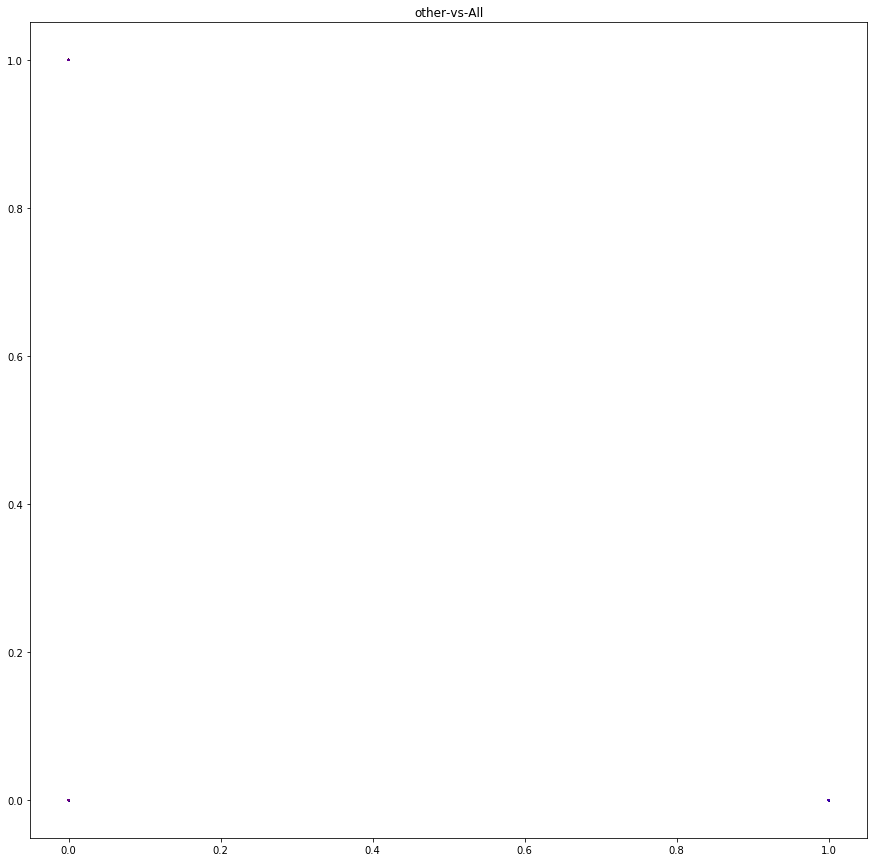

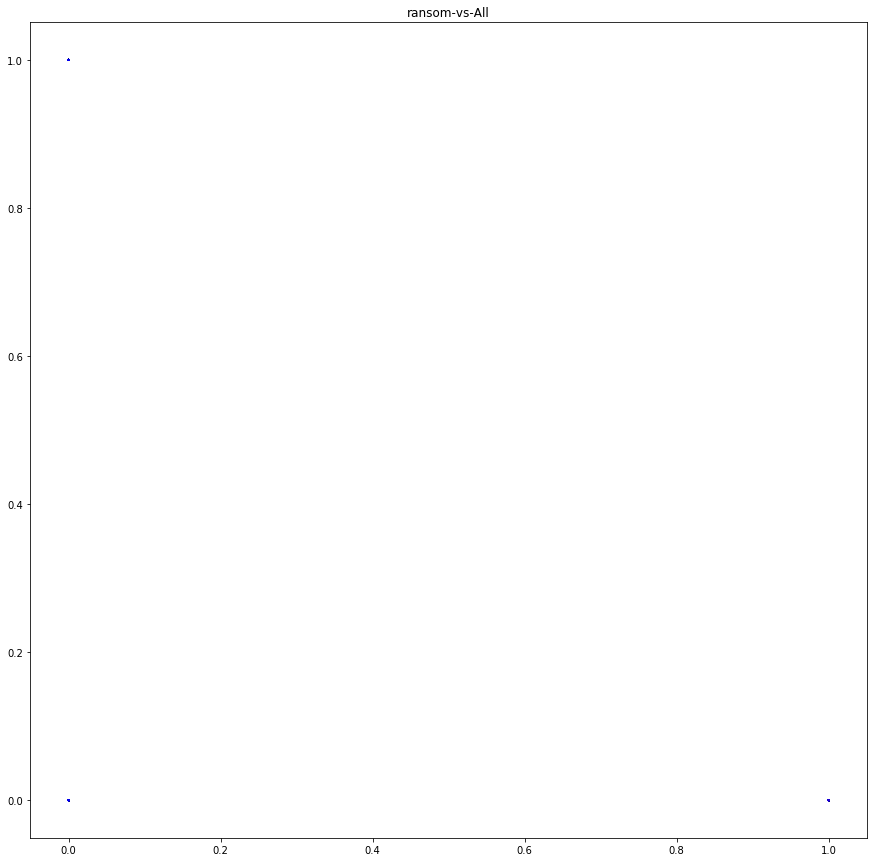

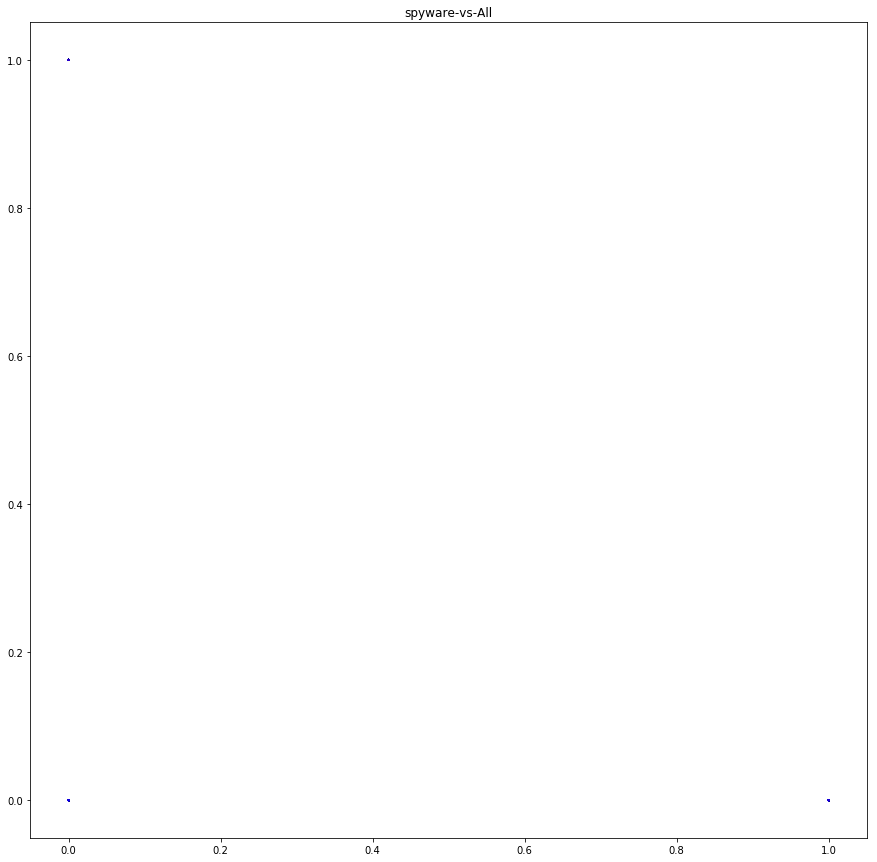

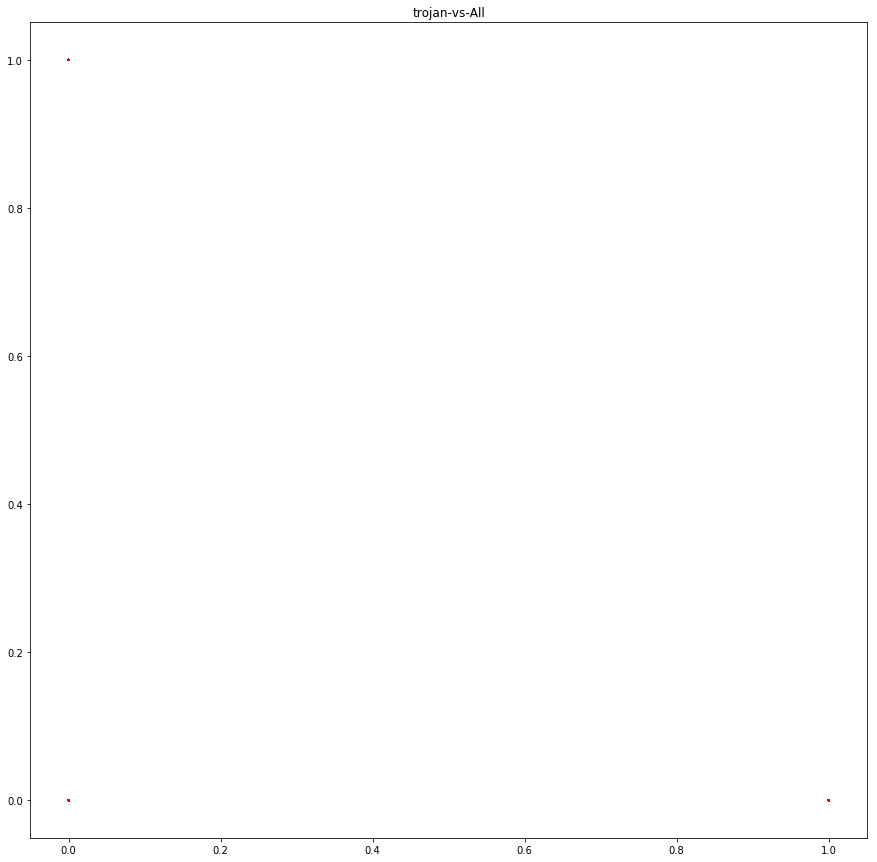

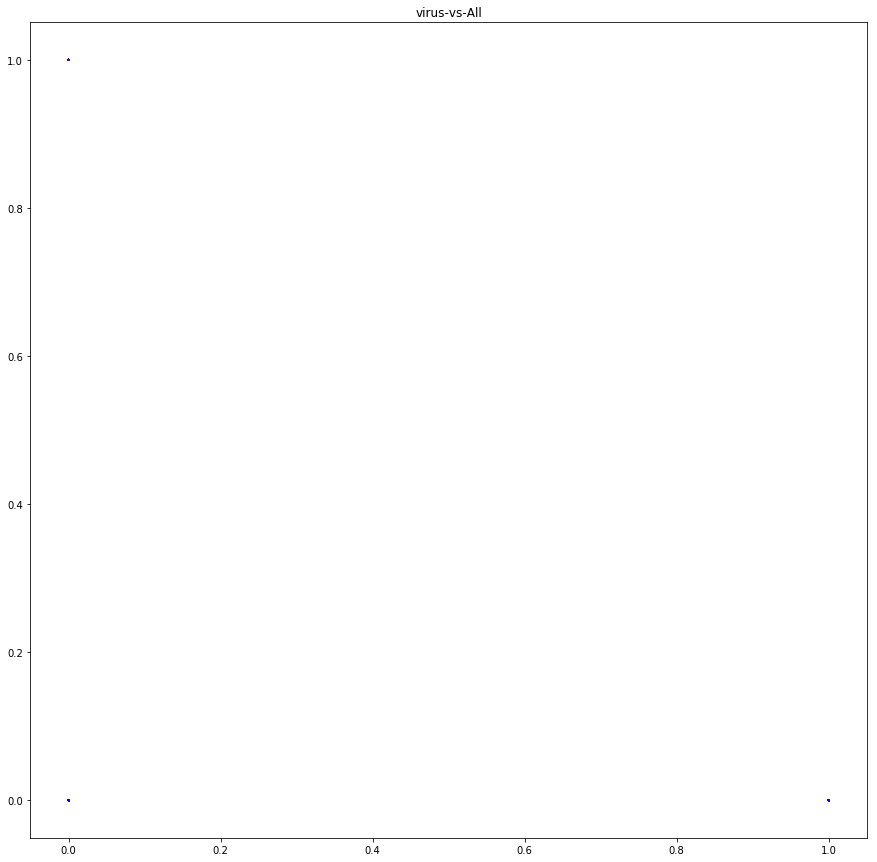

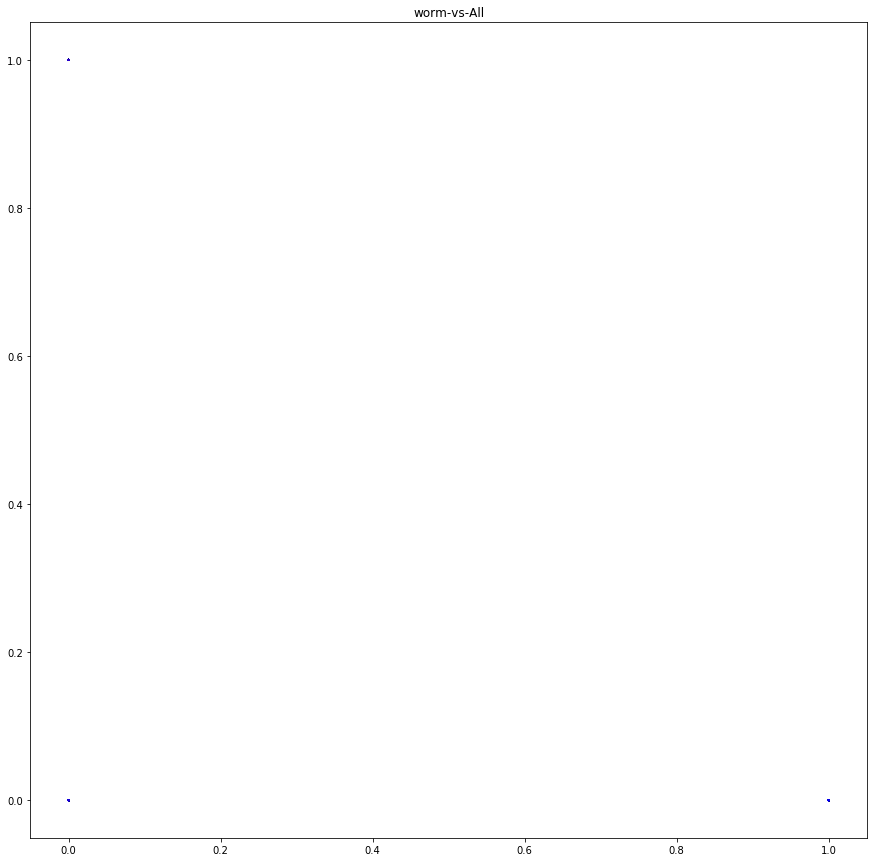

In [23]:
temp = pd.DataFrame(df.index).set_index('link')
for mal_type in malware_detailed.columns:
    malware = malware_detailed[mal_type].dropna()
    temp.loc[:, 'malware'] = 0
    temp.loc[temp.index.isin(malware.index), 'malware'] = 1
    
    plt.figure(figsize=(15, 15))
    plt.scatter(reduced_data[:,0], reduced_data[:,1], c=temp.malware, cmap='bwr', s=1, alpha=0.2)
    plt.title('{}-vs-All'.format(mal_type))
    plt.show()

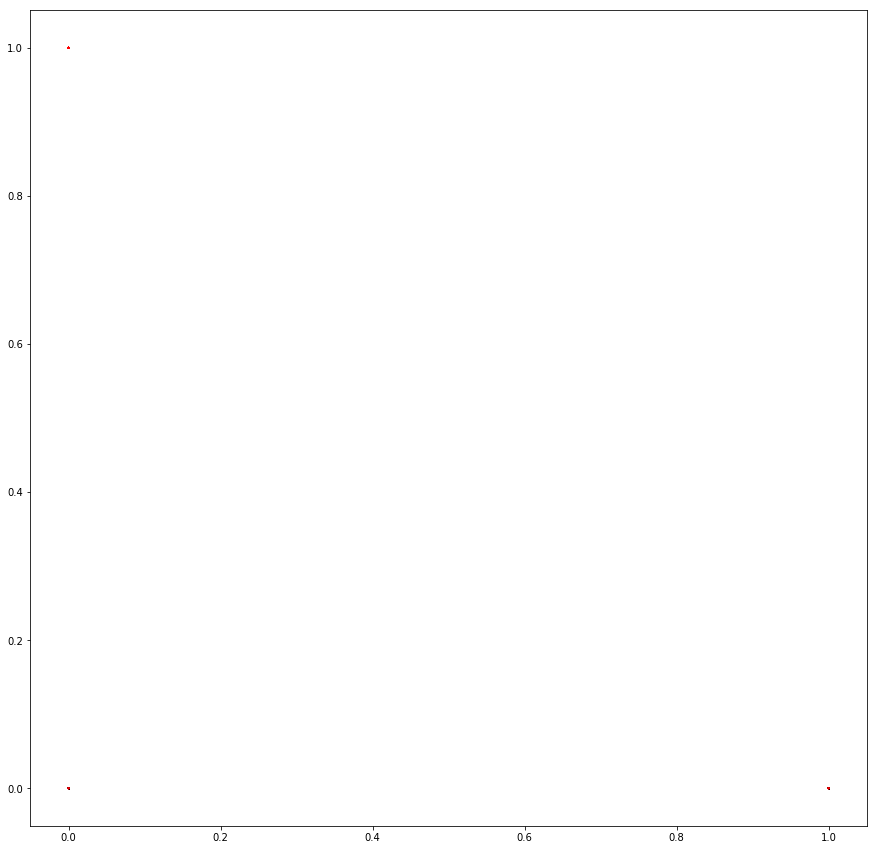

In [24]:
temp = pd.DataFrame(df.index).set_index('link')
temp.loc[:, 'malware'] = 1
temp.loc[temp.index.isin(goodware)] = 0
plt.figure(figsize=(15, 15))
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=temp.malware, cmap='bwr', s=1, alpha=0.1)
plt.show()